# ECON 515 Final Project - Time Series Analysis



In [1]:
pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary packages for time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Time series specific packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression





print("All packages loaded successfully!")
print("Ready for time series analysis!")


All packages loaded successfully!
Ready for time series analysis!


In [3]:
import seaborn as sns
sns.set_style("whitegrid")  # clean background style

## 1. Data Loading and Preprocessing {#data-loading}


In [4]:
# 1) WD

def parse_mixed_date(x):
    if pd.isna(x):
        return pd.NaT
    x = str(x).strip()
    # Case 1: looks like YYYY-MM-DD (first chunk has length 4)
    if "-" in x and len(x.split("-")[0]) == 4:
        return pd.to_datetime(x, format="%Y-%m-%d", errors="coerce")
    # Case 2: treat the rest as MM/DD/YYYY
    return pd.to_datetime(x, format="%m/%d/%Y", errors="coerce")


DATA_DIR = "/Users/wangxiyuan/515/project data"
# 2) Read & combine all ozone CSVs for 2010–2023 (or whatever is present)
files = sorted(glob.glob(os.path.join(DATA_DIR, "daily_44201_*.csv")))
print(f"Found {len(files)} files")
assert len(files) > 0, "No files matched daily_44201_*.csv"

# columns we care about (allowing legacy variants)
possible_cols = {
    "State Code", "State Name",
    "County Code", "County Name",
    "Site Number", "Site Num",          # either/or
    "Date Local",
    "Arithmetic Mean",
    "Units of Measure",
    "Sample Duration"
}

dfs = []
for f in files:
    # read only the columns that exist in this file (callable usecols)
    df = pd.read_csv(
        f,
        usecols=lambda c: c in possible_cols,  # keep intersection
        low_memory=False
    )

    # normalize column names
    if "Site Number" not in df.columns and "Site Num" in df.columns:
        df = df.rename(columns={"Site Num": "Site Number"})

    dfs.append(df)

oz_raw = pd.concat(dfs, ignore_index=True)
print("Combined shape:", oz_raw.shape)
print("Columns:", list(oz_raw.columns))

# Filter to Los Angeles County, CA
oz = oz_raw[
    ((oz_raw["State Name"] == "California") & (oz_raw["County Name"] == "Los Angeles"))
    | ((oz_raw["State Code"].astype(str) == "06") & (oz_raw["County Code"].astype(str) == "037"))
].copy()

# Tidy + parse dates
oz = oz.rename(columns={
    "Date Local": "date",
    "Arithmetic Mean": "ozone",
    "Units of Measure": "units"
})

#Original line (below) doesn't work because there are multiple different formats for dates in files
#We to handle each type of date prior to sorting via the function 'parse_mixed_date'
#oz["date"] = pd.to_datetime(oz["date"]) #keep commented
oz["date_parsed"] = oz["date"].apply(parse_mixed_date)
failed = oz[oz["date_parsed"].isna()] #this just checks to see if there are any failed dates data
print("Failed rows:", len(failed))
print(failed["date"].head(10))
oz["date"] = oz["date_parsed"]
oz = oz.drop(columns=["date_parsed"])

oz = oz.sort_values("date")

# Standardize units: convert ppb -> ppm when needed
if "Parts per billion" in set(oz["units"].astype(str)):
    m = oz["units"].astype(str).str.contains("Parts per billion", case=False, na=False)
    oz.loc[m, "ozone"] = oz.loc[m, "ozone"] / 1000.0
    oz.loc[m, "units"] = "Parts per million"

# Keep 8-hour O3 metric only (for consistency with standards)
oz = oz[oz["Sample Duration"].astype(str).str.contains("8", na=False)]

# County-wide daily average across monitors
daily_la = (oz.groupby("date", as_index=True)["ozone"]
              .mean()
              .to_frame("ozone"))

# Monthly average
monthly_la = daily_la.resample("MS").mean()

print(daily_la.head())  # Average of daily ozone level across all monitoring sites in LA county 
print(monthly_la.head())  # Average of all daily values in that month

daily_la.describe()
monthly_la.describe()

Found 14 files
Combined shape: (5471236, 9)
Columns: ['State Code', 'County Code', 'Site Number', 'Sample Duration', 'Date Local', 'Units of Measure', 'Arithmetic Mean', 'State Name', 'County Name']
Failed rows: 0
Series([], Name: date, dtype: object)
               ozone
date                
2010-01-01  0.018475
2010-01-02  0.016038
2010-01-03  0.015370
2010-01-04  0.009685
2010-01-05  0.010818
               ozone
date                
2010-01-01  0.014434
2010-02-01  0.020204
2010-03-01  0.029875
2010-04-01  0.034065
2010-05-01  0.034463


,ozone
count,168.000000
mean,0.030367
std,0.007800
min,0.013068
25%,0.023549
50%,0.033186
75%,0.036612
max,0.042222


In [5]:
# Install seaborn package
%pip install seaborn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


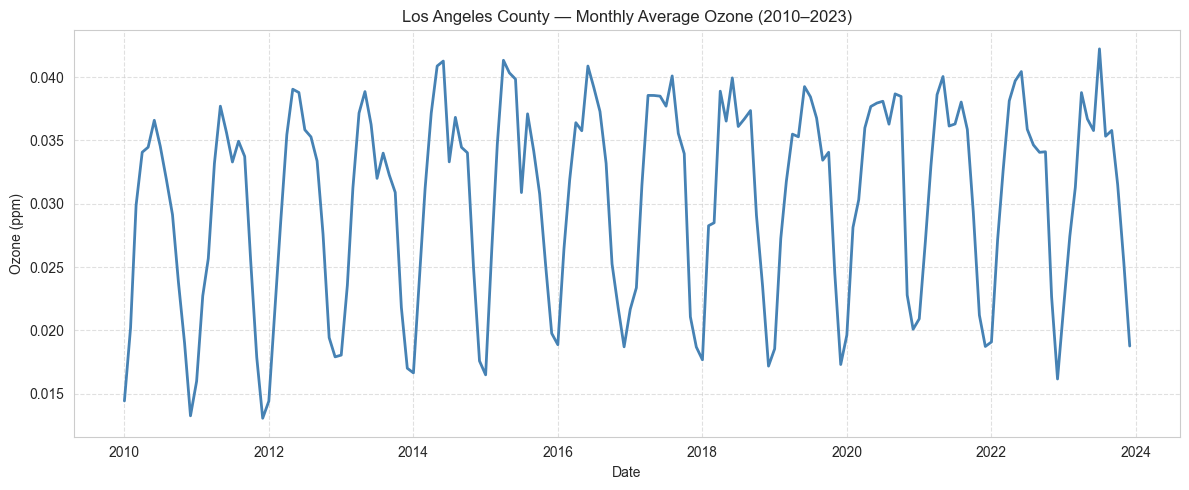

In [6]:
#Base PLot
plt.figure(figsize=(12,5))
plt.plot(monthly_la.index, monthly_la["ozone"], color="steelblue", lw=2)
plt.title("Los Angeles County — Monthly Average Ozone (2010–2023)")
plt.xlabel("Date")
plt.ylabel("Ozone (ppm)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Ozone (ppm)')

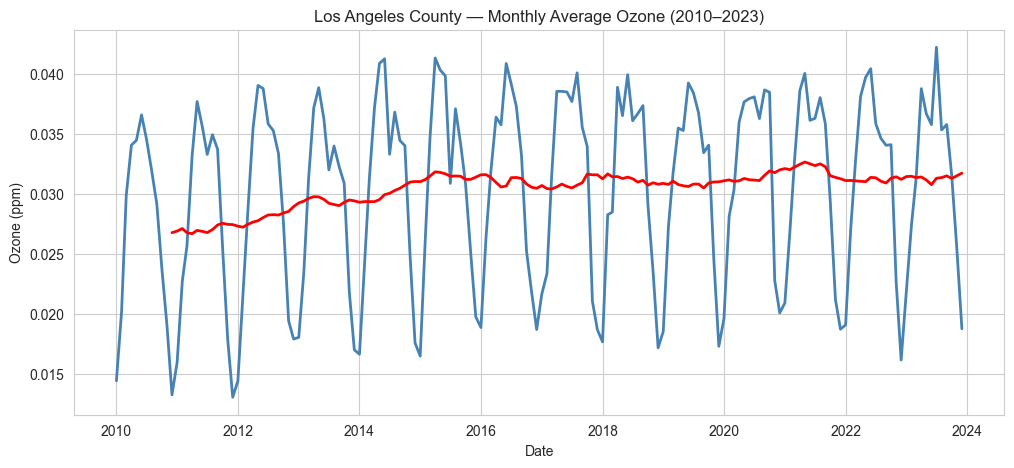

In [7]:
# Rolling Mean
plt.figure(figsize=(12,5))
plt.plot(monthly_la.index, monthly_la["ozone"], color="steelblue", lw=2)
plt.plot(monthly_la.index, monthly_la["ozone"].rolling(window=12).mean(), color="red", lw=2)
plt.title("Los Angeles County — Monthly Average Ozone (2010–2023)")
plt.xlabel("Date")
plt.ylabel("Ozone (ppm)")

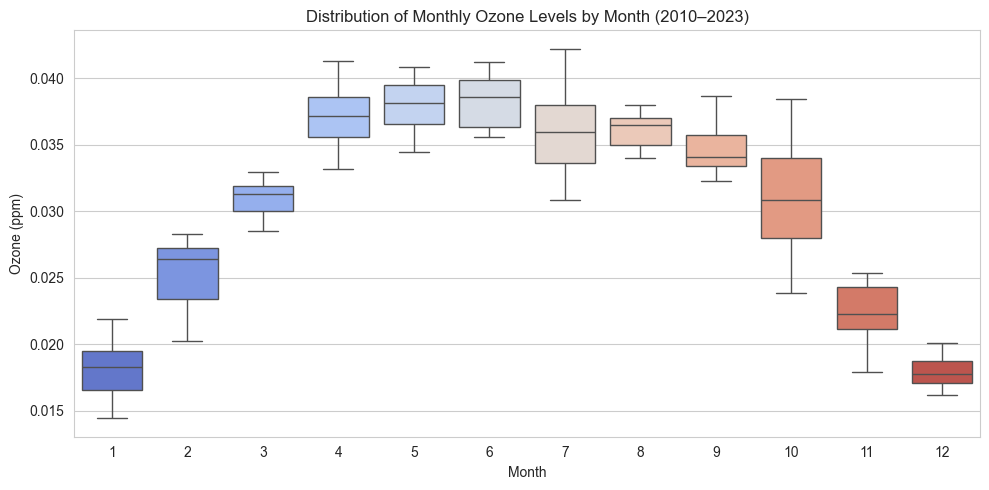

In [8]:
# Seasonal Pattern by Month (boxplot) 
monthly_la_sns = monthly_la.copy()
monthly_la_sns["month"] = monthly_la_sns.index.month

plt.figure(figsize=(10,5))
sns.boxplot(
    x="month",
    y="ozone",
    data=monthly_la_sns,
    palette="coolwarm",
    showfliers=False,  # optional: hide extreme outliers for a cleaner plot
)
plt.title("Distribution of Monthly Ozone Levels by Month (2010–2023)")
plt.xlabel("Month")
plt.ylabel("Ozone (ppm)")
plt.tight_layout()
plt.show()


In [9]:
pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the monthly ozone time series
y = monthly_la["ozone"].astype(float)
y.index = pd.to_datetime(y.index)
y = y.asfreq("MS")  # Ensure monthly start frequency

In [11]:
print(len(y))

168


In [12]:
split = int(len(y) * 0.8)
train = y[:split]   # Jan 2010 – Dec 2020 (approx)
test = y[split:]    # Jan 2021 – Dec 2023
test_steps = len(test)

In [13]:
y_log = np.log(y)
split_log = int(len(y_log) * 0.8)
train_log = y_log[:split_log]   # Jan 2010 – Dec 2020 (approx)
test_log = y_log[split_log:]    # Jan 2021 – Dec 2023
test_log_steps = len(test_log)

In [14]:
result = adfuller(train.dropna())
print("ADF p-value:", result[1])


ADF p-value: 0.3767400288619506


In [15]:
y_diff = y.diff().dropna()
result_diff = adfuller(y_diff)
print('p-value after 1st difference:', result_diff[1])

p-value after 1st difference: 2.2568124665885025e-20


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Take log transformation
y_log = np.log(y)

# Step 2: Take first difference of the log data
y_log_diff = y_log.diff().dropna()

y_log_diff = y.diff().dropna()
result_log_diff = adfuller(y_diff)
print('p-value after 1st difference log:', result_log_diff[1])

p-value after 1st difference log: 2.2568124665885025e-20


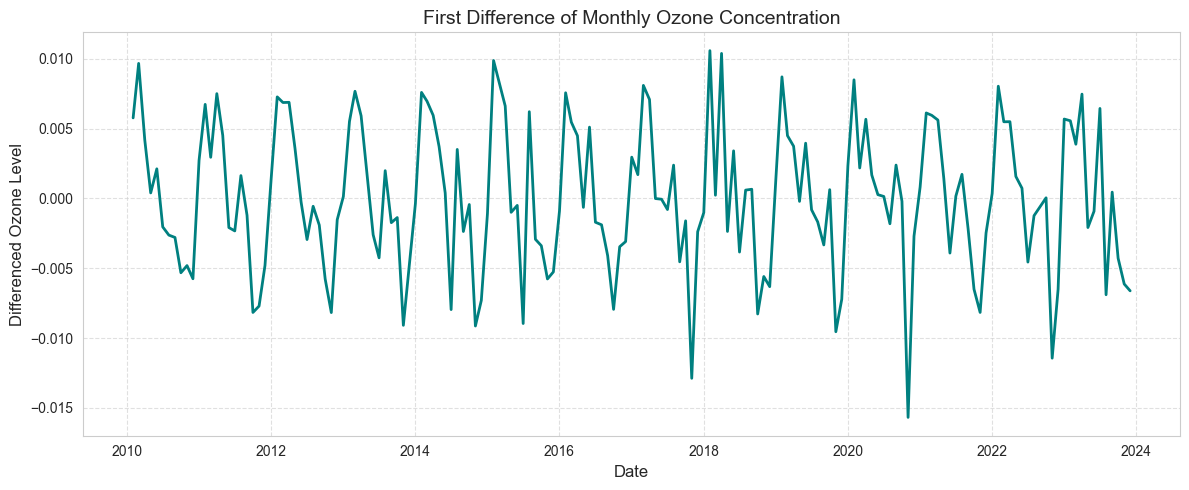

In [17]:
# Plot the first-differenced time series
plt.figure(figsize=(12, 5))
plt.plot(y_diff, color='teal', linewidth=2)
plt.title("First Difference of Monthly Ozone Concentration", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Differenced Ozone Level", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

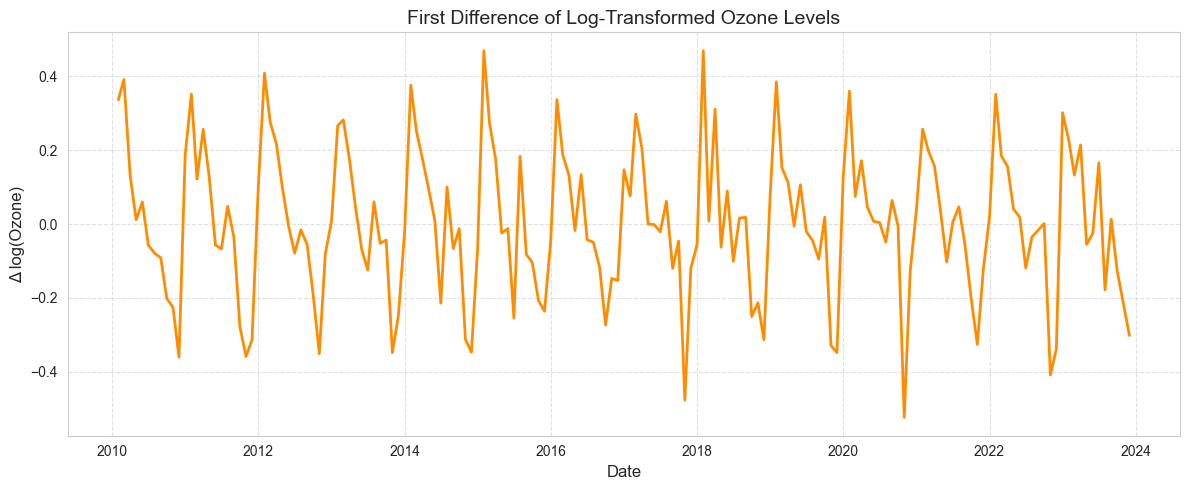

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Take log transformation
y_log = np.log(y)

# Step 2: Take first difference of the log data
y_log_diff = y_log.diff().dropna()

# Step 3: Plot
plt.figure(figsize=(12, 5))
plt.plot(y_log_diff, color='darkorange', linewidth=2)
plt.title("First Difference of Log-Transformed Ozone Levels", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Δ log(Ozone)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

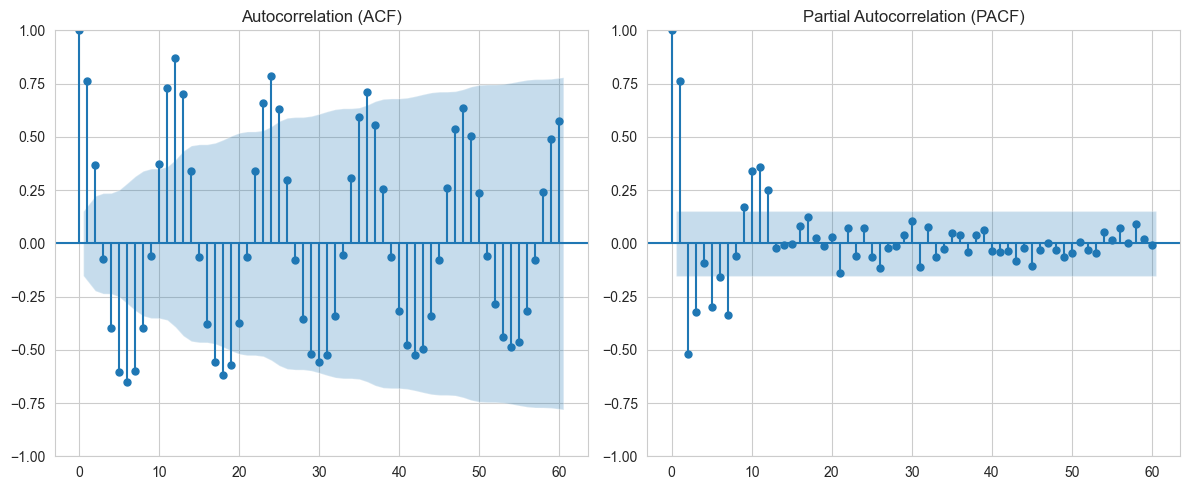

In [20]:
# Plot ACF and PACF to identify AR(p) and MA(q) terms

plt.figure(figsize=(12, 5))

# 1️⃣ Autocorrelation Function (ACF)
plt.subplot(1, 2, 1)
plot_acf(y.dropna(), lags=60, ax=plt.gca(), title="Autocorrelation (ACF)")

# 2️⃣ Partial Autocorrelation Function (PACF)
plt.subplot(1, 2, 2)
plot_pacf(y.dropna(), lags=60, ax=plt.gca(), title="Partial Autocorrelation (PACF)", method='ywm')

plt.tight_layout()
plt.show()

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# y = your monthly ozone series
# e.g. y = df['ozone']

# --- Train / Test split (e.g. last 3 years as test) ---
train_size = int(len(y) * 0.8)   # or choose a fixed date
train = y.iloc[:train_size]
test  = y.iloc[train_size:]
print(len(y))

168


In [93]:
# Fit SARIMA(1,1,1)(0,1,1,12) on TRAIN data only
sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              ozone   No. Observations:                  134
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 494.918
Date:                            Mon, 10 Nov 2025   AIC                           -981.837
Time:                                    14:18:24   BIC                           -971.146
Sample:                                01-01-2010   HQIC                          -977.503
                                     - 02-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2368      0.157      1.513      0.130      -0.070       0.544
ma.L1         -0.7860      0.142   

In [94]:
# Forecast the same length as the test set
n_test = len(test)
sarima_forecast = sarima_model.get_forecast(steps=n_test)

# Predicted mean series, aligned to test index
sarima_pred = pd.Series(
    sarima_forecast.predicted_mean.values,
    index=test.index
)
sarima_ci = sarima_forecast.conf_int()
sarima_ci.index = test.index

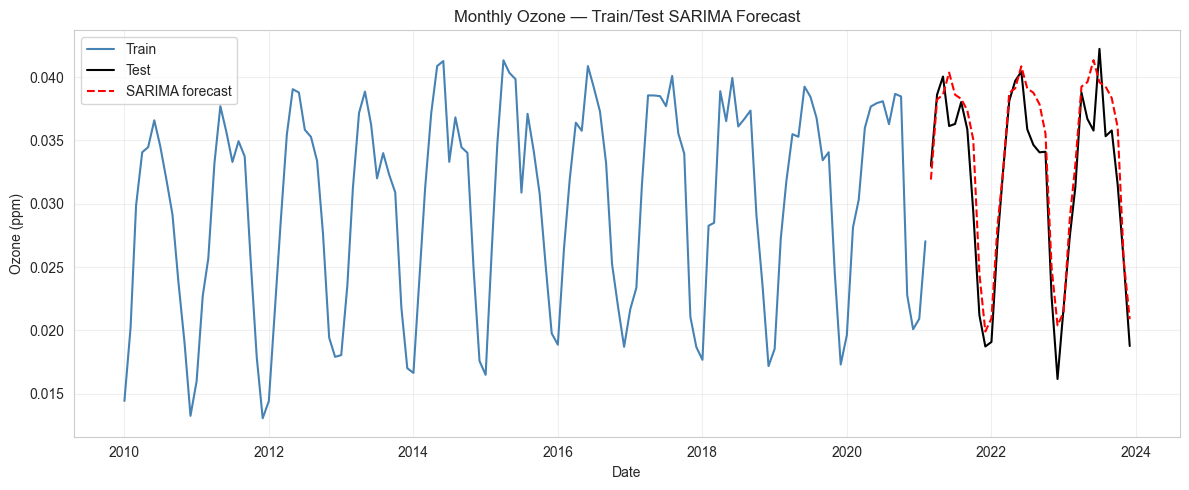

In [95]:
plt.figure(figsize=(12, 5))

plt.plot(train.index, train, label="Train", color="steelblue")
plt.plot(test.index,  test,  label="Test",  color="black")
plt.plot(sarima_pred.index, sarima_pred,
         label="SARIMA forecast", color="red", linestyle="--")

# Optional: shade 95% forecast interval
# plt.fill_between(
#     sarima_ci.index,
#     sarima_ci.iloc[:, 0],
#     sarima_ci.iloc[:, 1],
#     color="red", alpha=0.2, label="95% CI"
# )

plt.title("Monthly Ozone — Train/Test SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Ozone (ppm)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [96]:
# ==========================================================
# 1. Grid search SARIMA on log-transformed data (train_log)
# ==========================================================
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

y_log = y_log.dropna()
split_log = int(len(y_log) * 0.8)
train_log = y_log[:split_log]   # Jan 2010 – Dec 2020 (approx)
test_log = y_log[split_log:]    # Jan 2021 – Dec 2023
test_log_steps = len(test_log)

m = 12                      # seasonal period (12 months)
p = d = q = range(0, 2)     # p,q in {0,1}; d we'll fix to 1
P = D = Q = range(0, 2)     # P,Q in {0,1}; D we'll fix to 1

best_aic = np.inf
best_order = None
best_seasonal = None
best_model_log = None

for i in p:
    for j in [1]:          # d = 1
        for k in q:
            for si in P:
                for sj in [1]:   # D = 1
                    for sk in Q:
                        order = (i, j, k)
                        seasonal_order = (si, sj, sk, m)
                        try:
                            model = SARIMAX(
                                train_log,                   # LOG-transformed training data
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            ).fit(disp=False, maxiter=500)

                            if model.aic < best_aic:
                                best_aic_log = model.aic
                                best_order_log = order
                                best_seasonal_log = seasonal_order
                                best_model_log = model
                        except Exception:
                            continue

print("Best AIC (log SARIMA):", best_aic_log)
print("Best order_log (p,d,q):", best_order_log)
print("Best seasonal_log (P,D,Q,m):", best_seasonal_log)


model = SARIMAX(
    train_log,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False, maxiter=500)

# when forecasting:
sarima_log_forecast_log = best_model_log.get_forecast(steps=len(test_log)).predicted_mean
sarima_log_forecast = np.exp(sarima_log_forecast_log)

# Compare with actual ozone values (ORIGINAL scale!)
sarima_log_mae  = mean_absolute_error(test, sarima_log_forecast)
sarima_log_rmse = mean_squared_error(test, sarima_log_forecast) ** 0.5  # sqrt(MSE)
print("sarima_log_mae:", sarima_log_mae)
print("sarima_log_rmse:", sarima_log_rmse)

Best AIC (log SARIMA): -222.64810833778338
Best order_log (p,d,q): (1, 1, 1)
Best seasonal_log (P,D,Q,m): (1, 1, 1, 12)
sarima_log_mae: 0.0020902633808581052
sarima_log_rmse: 0.002631469584174127


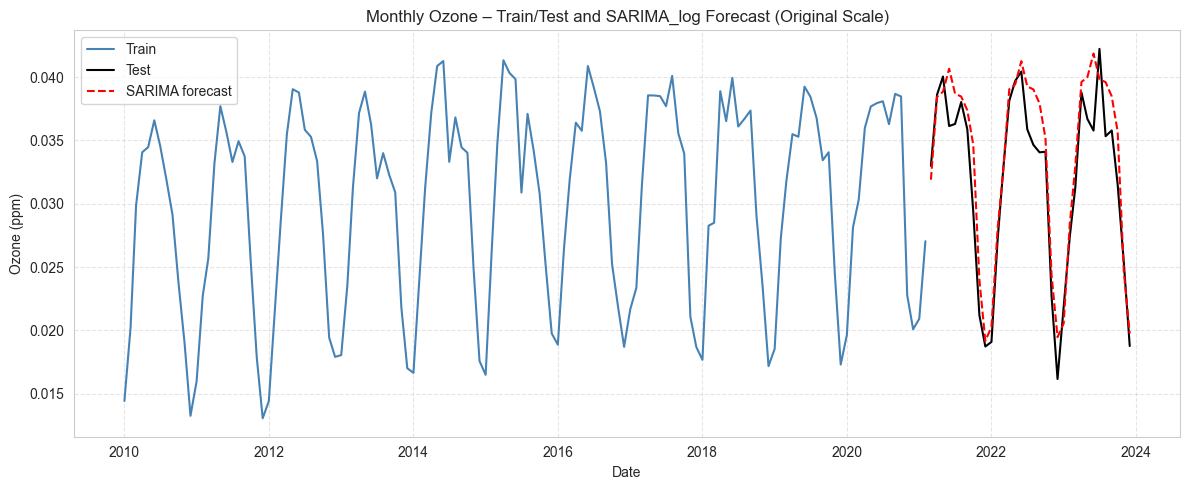

In [27]:
plt.figure(figsize=(12, 5))

plt.plot(train_log.index, np.exp(train_log), label="Train", color="steelblue")
plt.plot(test_log.index,  np.exp(test_log),  label="Test",  color="black")

plt.plot(test_log.index, sarima_log_forecast,
         label="SARIMA forecast", color="red", linestyle="--")

plt.title("Monthly Ozone – Train/Test and SARIMA_log Forecast (Original Scale)")
plt.xlabel("Date")
plt.ylabel("Ozone (ppm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [70]:
from pandas.tseries.offsets import MonthBegin
best_order = (1, 1, 1)
best_seasonal = (0, 1, 1, 12)

# Refit on the full series y
final_sarima = SARIMAX(
    y,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(final_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              ozone   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 656.510
Date:                            Mon, 10 Nov 2025   AIC                          -1305.021
Time:                                    14:01:08   BIC                          -1293.226
Sample:                                01-01-2010   HQIC                         -1300.228
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3639      0.081      4.520      0.000       0.206       0.522
ma.L1         -0.9647      0.029   

In [62]:
best_order_log = (1, 1, 1)
best_seasonal_log = (0, 1, 1, 12)

final_sarima_log = SARIMAX(
    y_log,
    order=best_order_log,
    seasonal_order=best_seasonal_log,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print("\n================ SARIMA_log Results ================\n")
print(final_sarima_log.summary())





================ SARIMA_log Results ================

                                     SARIMAX Results                                      
Dep. Variable:                          ozone_log   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 157.763
Date:                            Mon, 10 Nov 2025   AIC                           -307.526
Time:                                    11:45:58   BIC                           -295.730
Sample:                                01-01-2010   HQIC                          -302.732
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1865      0.085      2.195      0.028     

In [98]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# y_log = np.log(y)   # make sure y_log is defined before this

# ========= 1. Train / test split (same split for all models) =========
split_idx = int(len(y_log) * 0.8)
train_log = y_log.iloc[:split_idx]
test_log  = y_log.iloc[split_idx:]

# ========= 2. Define models to test =========
orders_to_try = [
    {'order': (0, 1, 0), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (1, 1, 0), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (0, 1, 1), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 12)},
    {'order': (1, 1, 0), 'seasonal_order': (1, 1, 1, 12)}
]

# ========= 3. Evaluate each model (out-of-sample) =========
results_list = []

for params in orders_to_try:
    order = params['order']
    seasonal = params['seasonal_order']
    
    try:
        print(f"\nFitting SARIMA{order}x{seasonal} on TRAIN ...")
        
        # ---- fit on training data only ----
        model = SARIMAX(
            train_log,
            order=order,
            seasonal_order=seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        # ---- forecast over the test period ----
        n_test = len(test_log)
        forecast_res = model.get_forecast(steps=n_test)
        y_pred_log = forecast_res.predicted_mean

        # ---- back-transform to original scale ----
        y_pred = np.exp(y_pred_log)        # forecasted ozone
        y_true = np.exp(test_log)          # actual ozone in test period
        
        # ---- out-of-sample metrics ----
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        aic = model.aic   # AIC for train fit
        
        results_list.append({
            'Model': f"SARIMA{order}x{seasonal}",
            'MAE': mae,
            'RMSE': rmse,
            'AIC': aic
        })
        
        print(f"✅ Done: MAE={mae:.6f}, RMSE={rmse:.6f}, AIC={aic:.3f}")
    
    except Exception as e:
        print(f"⚠️ Model SARIMA{order}x{seasonal} failed: {e}")

# ========= 4. Combine results into a DataFrame =========
results_df = pd.DataFrame(results_list)
print("\n================== Model Comparison (Test Set) ==================")
print(results_df.sort_values('MAE', ascending=True).reset_index(drop=True))



Fitting SARIMA(0, 1, 0)x(0, 1, 0, 12) on TRAIN ...
✅ Done: MAE=0.002931, RMSE=0.003599, AIC=-160.893

Fitting SARIMA(1, 1, 0)x(0, 1, 0, 12) on TRAIN ...
✅ Done: MAE=0.002351, RMSE=0.002944, AIC=-183.479

Fitting SARIMA(0, 1, 1)x(0, 1, 0, 12) on TRAIN ...
✅ Done: MAE=0.002661, RMSE=0.003446, AIC=-221.335

Fitting SARIMA(1, 1, 1)x(0, 1, 0, 12) on TRAIN ...
✅ Done: MAE=0.002705, RMSE=0.003515, AIC=-222.229

Fitting SARIMA(1, 1, 1)x(0, 1, 1, 12) on TRAIN ...
✅ Done: MAE=0.002088, RMSE=0.002629, AIC=-224.666

Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12) on TRAIN ...
✅ Done: MAE=0.002090, RMSE=0.002631, AIC=-222.648

Fitting SARIMA(1, 1, 0)x(1, 1, 1, 12) on TRAIN ...
✅ Done: MAE=0.002190, RMSE=0.002761, AIC=-194.552

================== Model Comparison (Test Set) ==================
                           Model       MAE      RMSE         AIC
0  SARIMA(1, 1, 1)x(0, 1, 1, 12)  0.002088  0.002629 -224.666330
1  SARIMA(1, 1, 1)x(1, 1, 1, 12)  0.002090  0.002631 -222.648108
2  SARIMA(1, 1, 0)x(1, 1

In [99]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# y = your original (non-log) time series, e.g.:
# y = df['ozone']   # make sure it's a pandas Series

# ========= 0. Train / test split (80% / 20%) =========
split_idx = int(len(y) * 0.8)
train_y = y.iloc[:split_idx]
test_y  = y.iloc[split_idx:]

# ========= 1. Define the SARIMA orders you want to test =========
orders_to_try = [
    {'order': (0, 1, 0), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (1, 1, 0), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (0, 1, 1), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (0, 1, 0, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (0, 1, 1, 12)},
    {'order': (1, 1, 1), 'seasonal_order': (1, 1, 0, 12)},
]

results_list = []

# ========= 2. Fit each model and compute MAE, RMSE, AIC =========
for params in orders_to_try:
    order = params['order']
    seasonal = params['seasonal_order']
    model_name = f"SARIMA{order}x{seasonal}"

    try:
        print(f"\nFitting {model_name} on TRAIN (original y) ...")

        # Fit SARIMA on training data only
        model = SARIMAX(
            train_y,
            order=order,
            seasonal_order=seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        # Forecast over the test period
        n_test = len(test_y)
        forecast_res = model.get_forecast(steps=n_test)
        y_hat = pd.Series(forecast_res.predicted_mean.values,
                          index=test_y.index)

        # Metrics on ORIGINAL scale (out-of-sample)
        mae  = mean_absolute_error(test_y, y_hat)
        rmse = np.sqrt(mean_squared_error(test_y, y_hat))
        aic  = model.aic   # AIC for the fit on train data

        results_list.append({
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'AIC': aic
        })

        print(f"✅ Done: MAE={mae:.6f}, RMSE={rmse:.6f}, AIC={aic:.3f}")

    except Exception as e:
        print(f"⚠️ {model_name} failed: {e}")

# ========= 3. Put everything into a table =========
results_df = pd.DataFrame(results_list)

print("\n================== SARIMA(y) Model Comparison (Test Set) ==================")
# sort by MAE (or AIC if you prefer)
print(results_df.sort_values('MAE', ascending=True).reset_index(drop=True))


Fitting SARIMA(0, 1, 0)x(0, 1, 0, 12) on TRAIN (original y) ...
✅ Done: MAE=0.002802, RMSE=0.003449, AIC=-1017.199

Fitting SARIMA(1, 1, 0)x(0, 1, 0, 12) on TRAIN (original y) ...
✅ Done: MAE=0.002389, RMSE=0.002975, AIC=-1036.400

Fitting SARIMA(0, 1, 1)x(0, 1, 0, 12) on TRAIN (original y) ...
✅ Done: MAE=0.002562, RMSE=0.003245, AIC=-1048.141

Fitting SARIMA(1, 1, 1)x(0, 1, 0, 12) on TRAIN (original y) ...
✅ Done: MAE=0.002634, RMSE=0.003348, AIC=-1069.891

Fitting SARIMA(1, 1, 1)x(0, 1, 1, 12) on TRAIN (original y) ...
✅ Done: MAE=0.002164, RMSE=0.002685, AIC=-981.837

Fitting SARIMA(1, 1, 1)x(1, 1, 0, 12) on TRAIN (original y) ...
✅ Done: MAE=0.002578, RMSE=0.003208, AIC=-977.950

================== SARIMA(y) Model Comparison (Test Set) ==================
                           Model       MAE      RMSE          AIC
0  SARIMA(1, 1, 1)x(0, 1, 1, 12)  0.002164  0.002685  -981.836969
1  SARIMA(1, 1, 0)x(0, 1, 0, 12)  0.002389  0.002975 -1036.400027
2  SARIMA(0, 1, 1)x(0, 1, 0, 12

In [101]:
last_date = y.index[-1]              # e.g., 2023-12-01
target_end = pd.Timestamp("2028-12-01")

months_ahead = (target_end.year - last_date.year) * 12 + (target_end.month - last_date.month)
print("Months to forecast:", months_ahead)

sarima_future = final_sarima.forecast(steps=months_ahead)

future_index = pd.date_range(
    start=last_date + MonthBegin(1),
    periods=months_ahead,
    freq="MS"
)

sarima_future_series = pd.Series(sarima_future.values, index=future_index, name="SARIMA forecast")
# === Display SARIMA order details ===
def show_sarima_order(model):
    order = model.model_orders.get("ar", 0), model.model_orders.get("diff", 0), model.model_orders.get("ma", 0)
    seasonal_order = model.model_orders.get("seasonal_ar", 0), model.model_orders.get("seasonal_diff", 0), model.model_orders.get("seasonal_ma", 0), model.specification.seasonal_periods

    print("Non-seasonal order (p, d, q):", model.model.order)
    print("Seasonal order (P, D, Q, s):", model.model.seasonal_order)

# Call it on your fitted model
show_sarima_order(final_sarima)

Months to forecast: 60
Non-seasonal order (p, d, q): (1, 1, 1)
Seasonal order (P, D, Q, s): (0, 1, 1, 12)


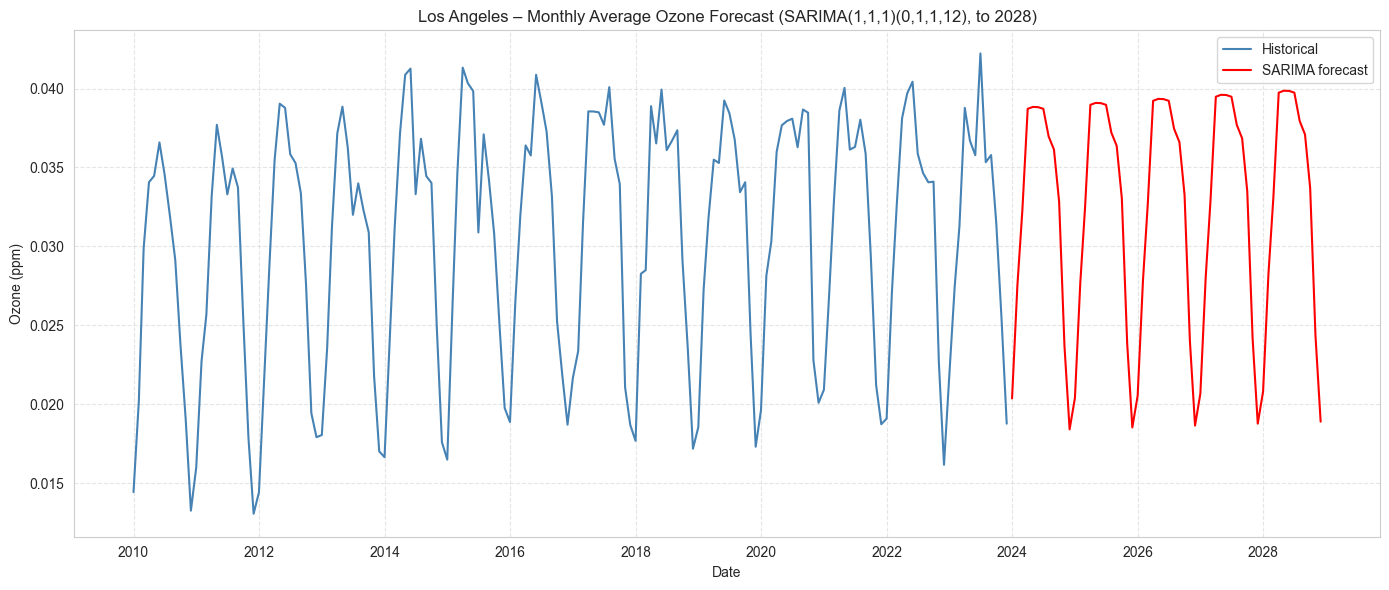

In [100]:
plt.figure(figsize=(14,6))

plt.plot(y.index, y, label="Historical", color="steelblue")
plt.plot(sarima_future_series.index, sarima_future_series, label="SARIMA forecast", color="red")

plt.title("Los Angeles – Monthly Average Ozone Forecast (SARIMA(1,1,1)(0,1,1,12), to 2028)")
plt.xlabel("Date")
plt.ylabel("Ozone (ppm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [102]:
import pandas as pd

# --- Define target forecast date ---
target_date = pd.Timestamp("2028-07-01")

# --- Make sure your forecast already goes far enough ---
# (You already created sarima_future_series in your code)
print("Forecast range:", sarima_future_series.index.min(), "to", sarima_future_series.index.max())

# --- Extract forecast value at the target date ---
if target_date in sarima_future_series.index:
    forecast_value = sarima_future_series.loc[target_date]
    print(f"SARIMA forecast for {target_date.date()}: {forecast_value:.6f}")
else:
    print(f"{target_date.date()} is not in the forecast range. You may need to extend 'target_end'.")

Forecast range: 2024-01-01 00:00:00 to 2028-12-01 00:00:00
SARIMA forecast for 2028-07-01: 0.039407


In [103]:
import pandas as pd

# --- Define target forecast date ---
target_date = pd.Timestamp("2028-08-01")

# --- Make sure your forecast already goes far enough ---
# (You already created sarima_future_series in your code)
print("Forecast range:", sarima_future_series.index.min(), "to", sarima_future_series.index.max())

# --- Extract forecast value at the target date ---
if target_date in sarima_future_series.index:
    forecast_value = sarima_future_series.loc[target_date]
    print(f"SARIMA forecast for {target_date.date()}: {forecast_value:.6f}")
else:
    print(f"{target_date.date()} is not in the forecast range. You may need to extend 'target_end'.")

Forecast range: 2024-01-01 00:00:00 to 2028-12-01 00:00:00
SARIMA forecast for 2028-08-01: 0.037674


In [32]:
# --- Define forecast horizon ---
last_date = y.index[-1]                          # e.g., 2023-12-01
target_end = pd.Timestamp("2028-12-01")

months_ahead = (target_end.year - last_date.year) * 12 + (target_end.month - last_date.month)
print("Months to forecast:", months_ahead)

# --- Forecast with log-transformed SARIMA model ---
sarima_future_log = final_sarima_log.get_forecast(steps=months_ahead)
sarima_future_log_mean = sarima_future_log.predicted_mean

# --- Back-transform from log(y) to original scale ---
sarima_future_original = np.exp(sarima_future_log_mean)

# --- Create future date index ---
future_index = pd.date_range(
    start=last_date + MonthBegin(1),
    periods=months_ahead,
    freq="MS"
)

# --- Combine into a pandas Series for plotting ---
sarima_future_series = pd.Series(
    sarima_future_original.values,
    index=future_index,
    name="SARIMA(log) forecast"
)

Months to forecast: 60


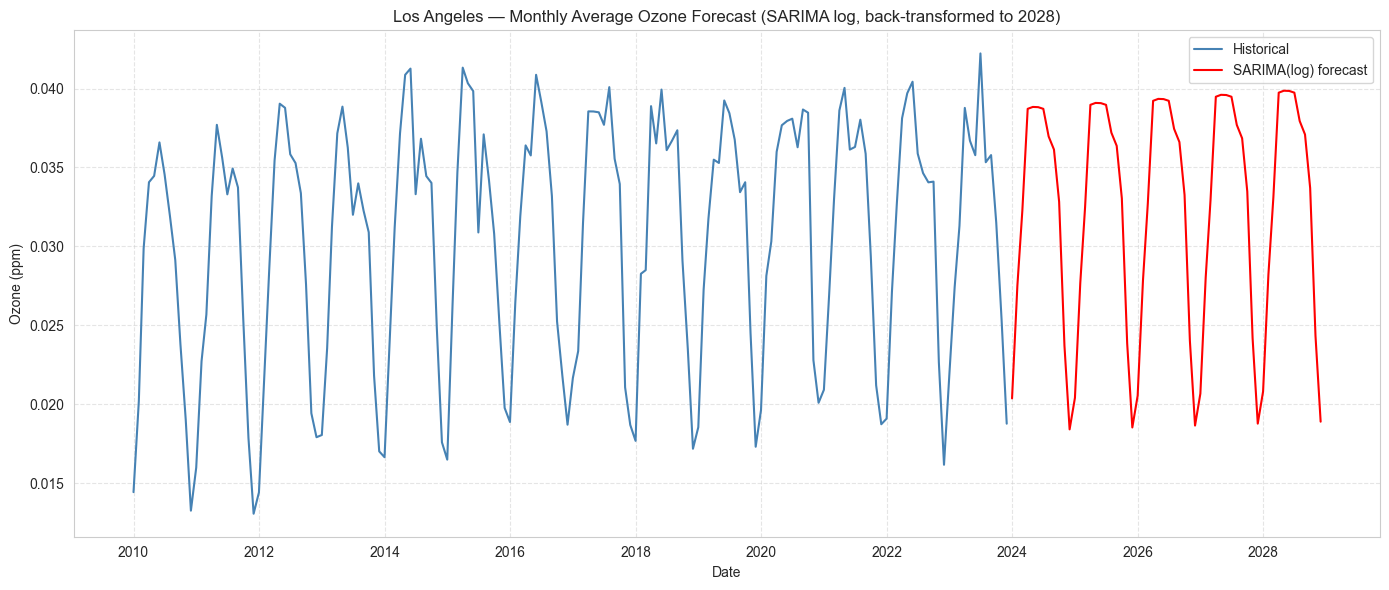

In [33]:
plt.figure(figsize=(14,6))

plt.plot(y.index, y, label="Historical", color="steelblue")
plt.plot(sarima_future_series.index, sarima_future_series,
         label="SARIMA(log) forecast", color="red")

plt.title("Los Angeles — Monthly Average Ozone Forecast (SARIMA log, back-transformed to 2028)")
plt.xlabel("Date")
plt.ylabel("Ozone (ppm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

best_aic_arima = np.inf
best_arima_order = None
best_arima_model = None

for p in range(0, 3):      # p = 0,1,2
    for q in range(0, 3):  # q = 0,1,2
        order = (p, 1, q)  # we know d=1 from ADF tests
        try:
            model = ARIMA(train, order=order).fit()
            if model.aic < best_aic_arima:
                best_aic_arima = model.aic
                best_arima_order = order
                best_arima_model = model
        except Exception as e:
            continue

print("Best ARIMA AIC  :", best_aic_arima)
print("Best ARIMA order:", best_arima_order)

Best ARIMA AIC  : -1054.6464116624431
Best ARIMA order: (0, 1, 2)


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- ARIMA forecast on test period ---
arima_test_forecast = best_arima_model.forecast(steps=len(test))

arima_mae  = mean_absolute_error(test, arima_test_forecast)
arima_rmse = mean_squared_error(test, arima_test_forecast) ** 0.5  # sqrt MSE

print("ARIMA test MAE :", arima_mae)
print("ARIMA test RMSE:", arima_rmse)

# --- SARIMA forecast on the same test period ---
sarima_test_forecast = final_sarima.get_forecast(steps=len(test)).predicted_mean

sarima_mae  = mean_absolute_error(test, sarima_test_forecast)
sarima_rmse = mean_squared_error(test, sarima_test_forecast) ** 0.5

print("SARIMA test MAE :", sarima_mae)
print("SARIMA test RMSE:", sarima_rmse)

# Compare with actual ozone values (ORIGINAL scale!)
sarima_log_mae  = mean_absolute_error(test, sarima_log_forecast)
sarima_log_rmse = mean_squared_error(test, sarima_log_forecast) ** 0.5  # sqrt(MSE)
print("sarima_log_mae:", sarima_log_mae)
print("sarima_log_rmse:", sarima_log_rmse)
def show_sarima_order(results):
    order = results.model.order            # (p, d, q)
    seasonal_order = results.model.seasonal_order   # (P, D, Q, s)
    print(f"Non-seasonal order (p,d,q): {order}")
    print(f"Seasonal order   (P,D,Q,s): {seasonal_order}")

# pass in the fitted model, not the forecast array
show_sarima_order(final_sarima_log)


ARIMA test MAE : 0.006571559260526705
ARIMA test RMSE: 0.007387782992544885
SARIMA test MAE : 0.007208129120489087
SARIMA test RMSE: 0.008380724884333548
sarima_log_mae: 0.0020902633808581052
sarima_log_rmse: 0.002631469584174127
Non-seasonal order (p,d,q): (1, 1, 1)
Seasonal order   (P,D,Q,s): (0, 1, 1, 12)


In [36]:
print("ARIMA AIC :", best_arima_model.aic)
print("SARIMA AIC:", final_sarima.aic)

ARIMA AIC : -1054.6464116624431
SARIMA AIC: -1367.2834163452994


In [37]:
print("ARIMA AIC:", best_arima_model.aic)
print("ARIMA BIC:", best_arima_model.bic)

print("SARIMA AIC:", final_sarima.aic)
print("SARIMA BIC:", final_sarima.bic)

ARIMA AIC: -1054.6464116624431
ARIMA BIC: -1045.9753642777778
SARIMA AIC: -1367.2834163452994
SARIMA BIC: -1358.192102581122


In [54]:
results = []
import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---------- 原始尺度 ----------
results.append(fit_and_eval("ARIMA(0,1,2)",
                            order=(0, 1, 2)))

results.append(fit_and_eval("SARIMA(0,1,0)(0,1,0,12)",
                            order=(0, 1, 0),
                            seasonal_order=(0, 1, 0, 12)))

results.append(fit_and_eval("SARIMA(1,1,0)(0,1,0,12)",
                            order=(1, 1, 0),
                            seasonal_order=(0, 1, 0, 12)))

results.append(fit_and_eval("SARIMA(0,1,1)(0,1,0,12)",
                            order=(0, 1, 1),
                            seasonal_order=(0, 1, 0, 12)))

results.append(fit_and_eval("SARIMA(1,1,1)(0,1,0,12)",
                            order=(1, 1, 1),
                            seasonal_order=(0, 1, 0, 12)))

# ---------- log 版本 ----------
results.append(fit_and_eval("SARIMA_log(0,1,0)(0,1,0,12)",
                            order=(0, 1, 0),
                            seasonal_order=(0, 1, 0, 12),
                            use_log=True))

results.append(fit_and_eval("SARIMA_log(1,1,0)(0,1,0,12)",
                            order=(1, 1, 0),
                            seasonal_order=(0, 1, 0, 12),
                            use_log=True))

results.append(fit_and_eval("SARIMA_log(0,1,1)(0,1,0,12)",
                            order=(0, 1, 1),
                            seasonal_order=(0, 1, 0, 12),
                            use_log=True))

results.append(fit_and_eval("SARIMA_log(1,1,1)(0,1,0,12)",
                            order=(1, 1, 1),
                            seasonal_order=(0, 1, 0, 12),
                            use_log=True))
results.append(fit_and_eval("SARIMA_log(1,1,1)(0,1,1,12)",
                            order=(1, 1, 1),
                            seasonal_order=(0, 1, 0, 12),
                            use_log=True))


In [40]:
table = pd.DataFrame(results).set_index("Model")

table = table.sort_values("RMSE")

print(table)

                                  MAE      RMSE          AIC
Model                                                       
SARIMA_log(1,1,0)(0,1,0,12)  0.002351  0.002944  -183.479278
SARIMA(1,1,0)(0,1,0,12)      0.002389  0.002975 -1036.400027
SARIMA(0,1,1)(0,1,0,12)      0.002562  0.003245 -1048.140603
SARIMA(1,1,1)(0,1,0,12)      0.002634  0.003348 -1069.890840
SARIMA_log(0,1,1)(0,1,0,12)  0.002661  0.003446  -221.334680
SARIMA(0,1,0)(0,1,0,12)      0.002802  0.003449 -1017.198533
SARIMA_log(1,1,1)(0,1,0,12)  0.002705  0.003515  -222.228684
SARIMA_log(1,1,1)(0,1,1,12)  0.002705  0.003515  -222.228684
SARIMA_log(0,1,0)(0,1,0,12)  0.002931  0.003599  -160.892759
ARIMA(0,1,2)                 0.006572  0.007388 -1054.646412
